# Aims of this script:

Analyse existing water tables to understand potential sources of error and undertake an uncertainty analysis.

To value-add existing water table maps by understanding flow directions, magnitudes, recharge/discharge zones, and geologic structures.

# Importing packages

In [316]:
import contextily
import flopy
from flopy.utils.reference import SpatialReference
import flopy.utils.binaryfile as bf
from flopy import mt3d
import fiona
import geopandas as gpd
from itertools import groupby
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
from osgeo import osr, gdal
import numpy as np
import pyproj
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import Affine
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from requests import Request
import shutil
import shapefile as sf
import subprocess
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
from owslib.wcs import WebCoverageService

#%matplotlib notebook

# Check out what versions I am using

To find out GDAL version: use command prompt
GDAL 2.3.3, released 2018/12/14. Got this by typing into conda prompt: `gdalinfo --version`

In [221]:
print('python version: {}' .format(sys.version))
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('pyproj version: {}'.format(pyproj.__version__))

python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.19.2
pandas version: 1.3.4
matplotlib version: 3.1.3
flopy version: 3.3.4
pyproj version: 3.2.1


# Set up the figure formatting

In [222]:
 wt_cmap = "viridis_r"
dem_cmap = "terrain"

# Set up folder structures

In [223]:
os.chdir(r'C:\Users\mar886\WaterTableProject\aewt_project')
print("Current Directory", os.getcwd())

# Make folders for data and figures
if not os.path.exists("input_data"):
    os.makedirs("input_data")
       
if not os.path.exists("figures"):
    os.makedirs("figures")
    
if not os.path.exists("output_data"):
    os.makedirs("output_data")

Current Directory C:\Users\mar886\WaterTableProject\aewt_project


# Projection set ups

In [224]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32755')
gda94 = pyproj.CRS('epsg:4283')

# DEM Data

Start with the DEM data to make the grid, this sets the shape for the other datasets to work with/crop to.

I am importing the ASCII file because I am having trouble working with GTiffs.

DEM is being imported from a folder, it has already been downloaded (i.e. not using web-server).

In [225]:
dem_rstr_nm_asc = os.path.join("input_data", "Elvis_dl_25Oct21",
                               "Hydro_Enforced_1_Second_DEM.asc")

### First read DEM data as a raster (with projection included)

This is similar to a Python file object, in that it is opened and read. Can check the mode (read or write) using `dem_rstr.mode` and check if its closed using `dem_rstr.closed`.

**I am still confused by the shape, here it says it is 2D but when I read it as an array, 3 indices are used**

In [226]:
dem_rstr = rio.open(dem_rstr_nm_asc)
print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print(dem_rstr.mode)
print(dem_rstr.closed)

DEM raster crs is: EPSG:4326
DEM raster shape: (4320, 4319)
DEM raster type: <class 'rasterio.io.DatasetReader'>
r
False


### Second, download the raster directly to be an array, with the metadata stored separately.

Instead of `dem_ar = grd.read()[0,:,:]` I could also use `dem_ar = grd.read(1)`, each band is indexed starting at 1 (not 0 like in Python).

The `bounds` bounding box will be used to set up extent throughout the code.

In [227]:
with rio.open(dem_rstr_nm_asc) as grd:
    dem_ar = grd.read()[0,:,:]
    grid_meta = grd.profile   
    bounds = grd.bounds
    res = grd.res

### Plot the DEM raster and array to show the differences

<IPython.core.display.Javascript object>


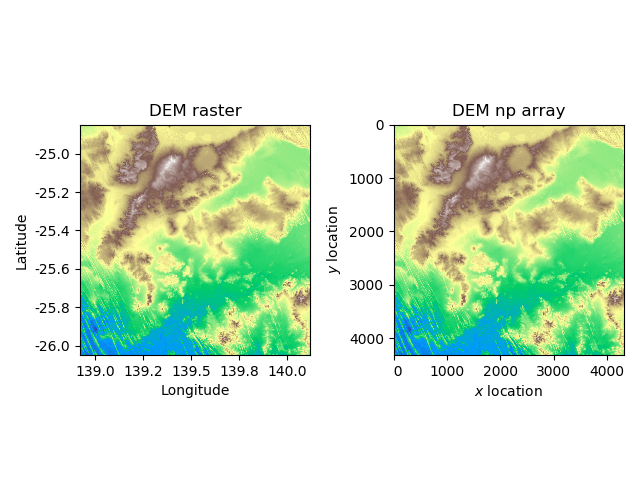

In [228]:
fig, (ax1, ax2) = plt.subplots(1, 2)

show(dem_rstr, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

ax2.imshow(dem_ar, cmap=dem_cmap)
ax2.set_xlabel("$x$ location")
ax2.set_ylabel("$y$ location")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))


ax1.set_title('DEM raster')
ax2.set_title('DEM np array')
plt.tight_layout()


## Set up the extent of the study area using the DEM extent

In [229]:
print("The shape of DEM is: %s" % (dem_ar.shape,))

mask = np.zeros_like(dem_ar)
nrows, ncols = np.shape(mask)

The shape of DEM is: (4320, 4319)


## Make a geodataframe of the bounding box to crop with.

Study extent as a polygon (`studyarea`) or geodataframe (`sa_gdf`).
Geodaframe is what seems to work best for cropping.

In [230]:
studyarea = shapely.geometry.box(bounds[0], bounds[1], bounds[2], bounds[3]) # minx, miny, maxx, maxy
print(type(studyarea))

print("Area of the study area is: %1.1f square degrees" % studyarea.area)
print("Length of the study area is: %1.1f square degrees" % studyarea.length)

sa_df = pd.DataFrame()

sa_df["geometry"] = [studyarea]

sa_gdf = gpd.GeoDataFrame(sa_df, geometry='geometry',crs=wgs84)
print(type(sa_gdf))

<class 'shapely.geometry.polygon.Polygon'>
Area of the study area is: 1.4 square degrees
Length of the study area is: 4.8 square degrees
<class 'geopandas.geodataframe.GeoDataFrame'>


### Convert study area bounding box to utm

This allows me to understand what the area is in metres.

Assign the x,y coordinates of the study area to a coordinates_array - sometimes I need different ways of accessing the same information!

In [ ]:
sa_gdf_utm = sa_gdf.to_crs(utm)
sa_gdf_utm.head()

coordinates_array = np.asarray(sa_gdf_utm.geometry[0].exterior.coords)[:-1] 
# Note that the first and last points are the same

# Check out the coordinates and see the warping
sa_gdf_utm.plot()
plt.plot(coordinates_array[0][0], coordinates_array[0][1], "m*", label="index=0")
plt.plot(coordinates_array[1][0], coordinates_array[1][1], "k.", label="index=1")
plt.plot(coordinates_array[2][0], coordinates_array[2][1], "g^", label="index=2")
plt.plot(coordinates_array[3][0], coordinates_array[3][1], "yP", label="index=3")
plt.legend()
axes = plt.gca()
axes.set_title('Study area bbox in utm')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [317]:
print(sa_gdf_utm.area)

0    1.625383e+10
dtype: float64


# Water table contours data

These are saved as shapefiles.

**I am getting a strange error message and I am not sure why**

In [232]:
wt_contour_fldr = os.path.join("input_data", "GAB_WT", "Watertable_Contour",
                               "wt_contour.shp")

wt_contour = gpd.read_file(wt_contour_fldr)

print("WT contour raster crs is: %s" % wt_contour.crs)

WT contour raster crs is: {'proj': 'aea', 'lat_1': -21, 'lat_2': -29, 'lat_0': 0, 'lon_0': 143, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}


### Plot the water table contours

Save the figure into the designated figures folder.

<IPython.core.display.Javascript object>


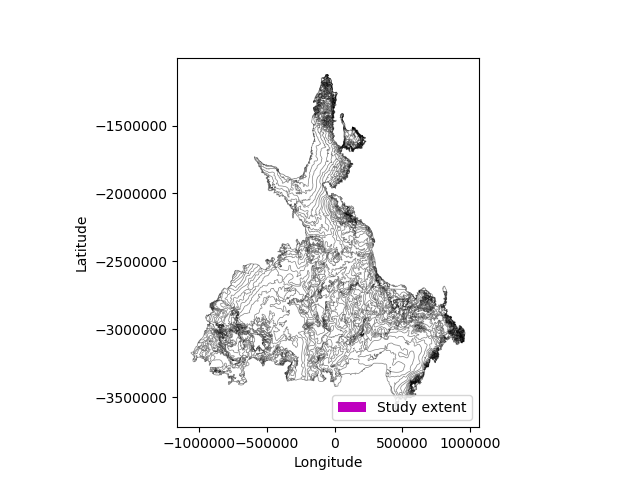

In [233]:
fig, ax = plt.subplots(1,1)
wt_contour.plot(ax=ax, color="k", alpha=0.5, linewidth=0.5)


ax.add_patch(mpl.patches.Polygon([[bounds[0], bounds[1]],   # bottom left
                                  [bounds[2], bounds[1]],   # bottom right
                                  [bounds[2], bounds[3]],   # top right
                                  [bounds[0], bounds[3]]],  # top left

                                  facecolor="m", edgecolor="m", closed=True, 
                                  lw=0, fill=True))

plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Make a legend

pmarks = []
color = "m"
label = "Study extent"
pmarks.append(Patch(facecolor=color, label=label))

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[*handles,*pmarks], loc='lower right')

# Save figure
plt.savefig(os.path.join("figures", "original_contours"), dpi=300)

### Convert the coordinates of water table contour to be the same as the DEM

In this case, it is already in WGS84 (EPSG 4326, same as the DEM), but I will keep this step for future reference.

In [234]:
wt_contour = wt_contour.to_crs(wgs84)
print("WT contour raster crs is: %s" % wt_contour.crs)

WT contour raster crs is: epsg:4326


### Have a look at the water table contours data

In [235]:
print(wt_contour.head(3))

   height descript     Shape_Leng  \
0     260  Contour   47873.380542   
1     220  Contour   40034.891209   
2     220  Contour  107748.016699   

                                            geometry  
0  LINESTRING (145.33224 -26.94083, 145.33272 -26...  
1  LINESTRING (144.82428 -27.04660, 144.82416 -27...  
2  LINESTRING (144.78225 -27.54287, 144.78623 -27...  


## Crop water table contours to the study area

### 1. Get rid of all of the contours that aren't water table contours (I.e. the GAB boundary).

In [236]:
wt_contour_filtr = wt_contour[wt_contour['height']>-9999]

if sa_gdf.crs == wt_contour_filtr.crs:
    print("Study area and water table contours are in the same crs")
else:
    print("Study area and water table contours are not in the same crs - conversion required")

Study area and water table contours are in the same crs


In [237]:
# Make a copy of the dataframe so I can add the intersection geoseries over the top
contours_icpt_gdf = wt_contour_filtr.copy()
print(len(wt_contour))
print(len(contours_icpt_gdf))

print(contours_icpt_gdf.head(3))

2832
1122
   height descript     Shape_Leng  \
0     260  Contour   47873.380542   
1     220  Contour   40034.891209   
2     220  Contour  107748.016699   

                                            geometry  
0  LINESTRING (145.33224 -26.94083, 145.33272 -26...  
1  LINESTRING (144.82428 -27.04660, 144.82416 -27...  
2  LINESTRING (144.78225 -27.54287, 144.78623 -27...  


### 2. Crop contours based on the study area

In [238]:
contours_icpt_gdf['contours_icpt'] = wt_contour_filtr.intersection(sa_gdf.geometry[0])

print(contours_icpt_gdf.head(3))

   height descript     Shape_Leng  \
0     260  Contour   47873.380542   
1     220  Contour   40034.891209   
2     220  Contour  107748.016699   

                                            geometry             contours_icpt  
0  LINESTRING (145.33224 -26.94083, 145.33272 -26...  GEOMETRYCOLLECTION EMPTY  
1  LINESTRING (144.82428 -27.04660, 144.82416 -27...  GEOMETRYCOLLECTION EMPTY  
2  LINESTRING (144.78225 -27.54287, 144.78623 -27...  GEOMETRYCOLLECTION EMPTY  


### 3. Get only values where the geometry is not empty

In [239]:
is_empty_list = []
for i in range(len(contours_icpt_gdf)):
    is_empty_list.append(contours_icpt_gdf.iloc[i, 4].is_empty)
len(is_empty_list)

contours_icpt_gdf['is_empty'] = is_empty_list
contours_icpt_gdf_notempty = contours_icpt_gdf[contours_icpt_gdf['is_empty'] == False]

print(len(contours_icpt_gdf_notempty))
print(contours_icpt_gdf_notempty.head(3))

5
      height descript    Shape_Leng  \
52        80  Contour  1.101543e+05   
53        60  Contour  6.944120e+04   
1755      40  Contour  3.068794e+06   

                                               geometry  \
52    LINESTRING (139.51758 -25.13959, 139.51526 -25...   
53    LINESTRING (139.60612 -25.97260, 139.60071 -25...   
1755  LINESTRING (141.12487 -31.08753, 141.12860 -31...   

                                          contours_icpt  is_empty  
52    LINESTRING (139.51758 -25.13959, 139.51526 -25...     False  
53    LINESTRING (139.60612 -25.97260, 139.60071 -25...     False  
1755  MULTILINESTRING ((140.08805 -26.04986, 140.075...     False  


### Plot the water table contours that intersect the study are and are not empty

<IPython.core.display.Javascript object>


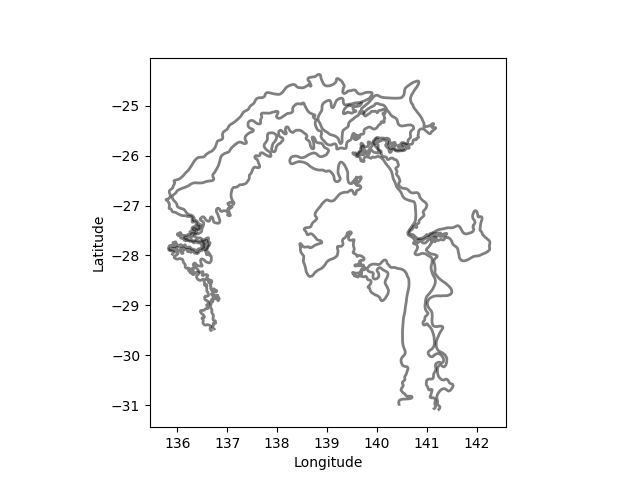

Text(0, 0.5, 'Latitude')

In [240]:
fig, ax = plt.subplots()
contours_icpt_gdf_notempty.plot(ax=ax, color="k", alpha=0.5, linewidth=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

### 4. Make a new gdf where the name geometry is changed

This is because the intercept column is actually the geometry.

Now it is a geopandas object and is the right shape, cropped to the study area.

In [241]:
contours_sa = contours_icpt_gdf_notempty.copy()
contours_sa = contours_sa.drop(labels="geometry", axis=1)
print(contours_sa.columns)
contours_sa = contours_sa.rename(columns={"contours_icpt":"geometry"})
print(len(contours_sa))
print(contours_sa.head(3))

Index(['height', 'descript', 'Shape_Leng', 'contours_icpt', 'is_empty'], dtype='object')
5
      height descript    Shape_Leng  \
52        80  Contour  1.101543e+05   
53        60  Contour  6.944120e+04   
1755      40  Contour  3.068794e+06   

                                               geometry  is_empty  
52    LINESTRING (139.51758 -25.13959, 139.51526 -25...     False  
53    LINESTRING (139.60612 -25.97260, 139.60071 -25...     False  
1755  MULTILINESTRING ((140.08805 -26.04986, 140.075...     False  


#### Plot the water table contours cropped to the study area

<IPython.core.display.Javascript object>


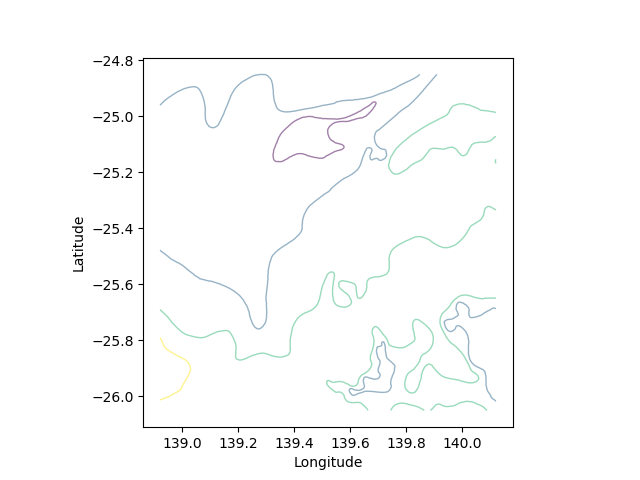

Text(0, 0.5, 'Latitude')

In [242]:
fig, ax = plt.subplots()
contours_sa.plot(ax=ax, column=contours_sa["height"], 
                 alpha=0.5, cmap=wt_cmap, linewidth=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### Plot the water table contours again with the study area extent to check they align

Study area extent is a grey box.

<IPython.core.display.Javascript object>


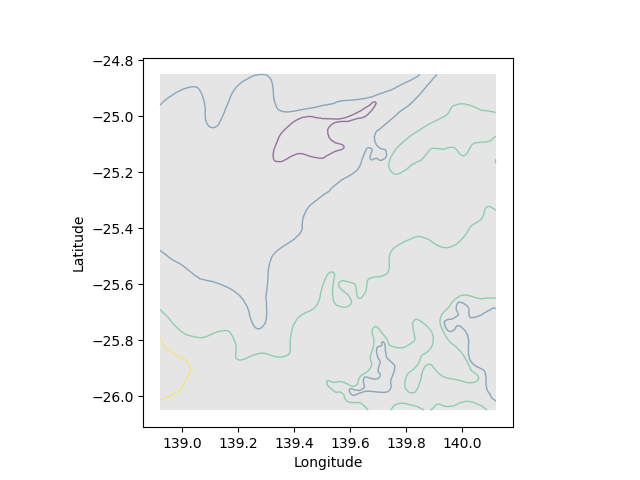

In [243]:
fig, ax = plt.subplots()
contours_sa.plot(ax=ax, column=contours_sa["height"], 
                 alpha=0.5, cmap=wt_cmap, linewidth=1)
sa_gdf.plot(ax=ax, color="0.8", alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Save figure
plt.savefig(os.path.join("figures", "cropped_contours"), dpi=300)

## Plot the DEM data with the water table contours 

Where the water table contours are shapefiles.

<IPython.core.display.Javascript object>


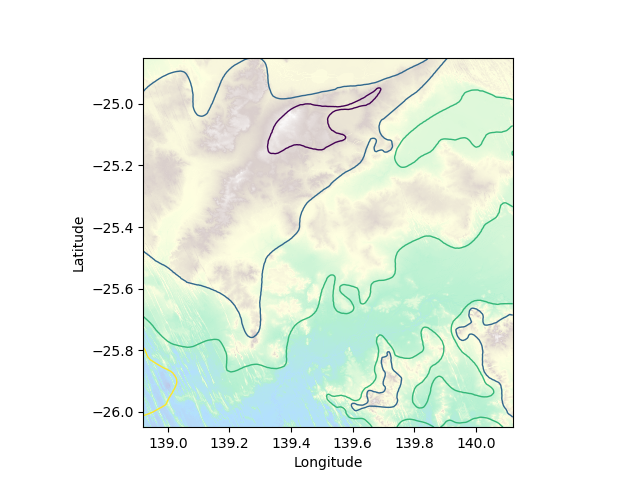

In [244]:
fig1, ax1 = plt.subplots()
show(dem_rstr, ax=ax1, cmap="terrain", alpha=0.3)
contours_sa.plot(ax=ax1, column=contours_sa["height"], 
                 linewidth=1, cmap=wt_cmap)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
axes_extent = ax1.axis()

plt.savefig(os.path.join("figures", "dem_with_contours"), dpi=300)

## Turn water table contours into a raster file

In [245]:
raster_wt = rasterize(
    ((s, h) for s, h in zip(contours_sa['geometry'], contours_sa['height'])),
    out_shape=dem_ar.shape,
    transform=grid_meta['transform'],
    fill = 0,
    all_touched = True,
    default_value = 0,
    dtype=rio.int32)

print("Min value for wt raster: %2.2f" %raster_wt.min())
print("Max value for wt raster: %2.2f" %raster_wt.max())
print("Shape of wt raster: %s" %(raster_wt.shape,))

Min value for wt raster: 0.00
Max value for wt raster: 80.00
Shape of wt raster: (4320, 4319)


### Plot the rasterised water level contours

<IPython.core.display.Javascript object>


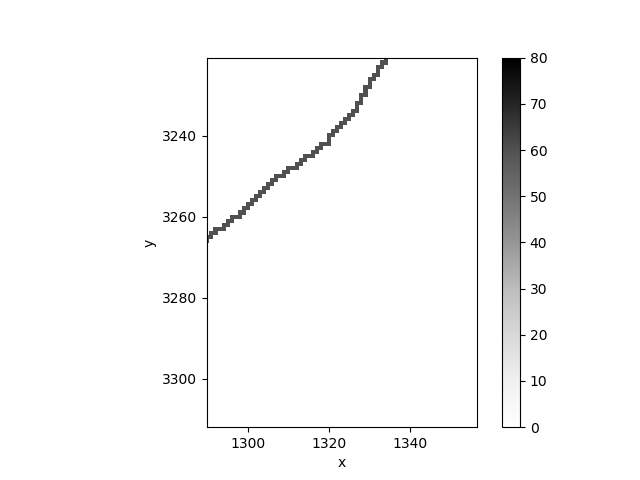

In [246]:
plt.figure()
plt.imshow(raster_wt, cmap='Greys')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

plt.savefig(os.path.join("figures", "raster_contours"), dpi=300)

# River network data

### First step: download river data from Geofabric.

Here I am accessing the data directly from a webservice. The  url accesses BoM Geofabric Surface Hydrology Cartography.

In [247]:
WfsUrl = 'http://geofabric.bom.gov.au/simplefeatures/ahgf_shcarto/ows'
params = dict(service='WFS', 
              version='1.0.0', 
              request='GetFeature',
              typename='ahgf_shcarto:AHGFMappedStream', 
              bbox='%f,%f,%f,%f' % (bounds[0],bounds[1],bounds[2],bounds[3]),
              outputFormat='json')

q = Request('GET',WfsUrl,params=params).prepare().url
riv_wgs = gpd.read_file(q)
riv_wgs.crs # Already in wgs84
river_gdf = riv_wgs.to_crs(wgs84)

C:\Users\mar886\Anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Plot the river network

<IPython.core.display.Javascript object>


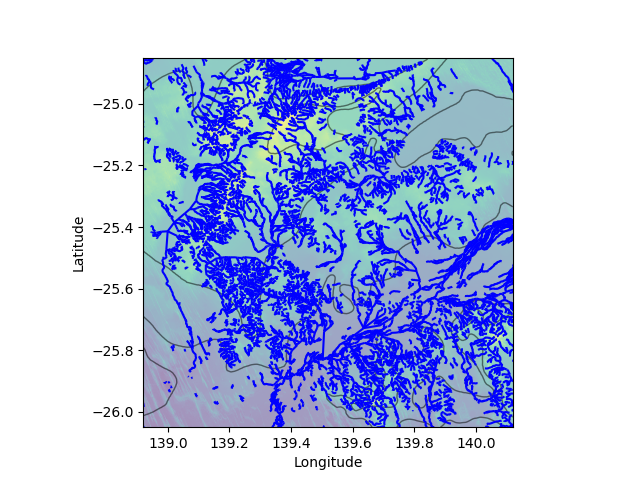

In [248]:
fig1, ax1 = plt.subplots()
show(dem_rstr, ax=ax1, alpha=0.5)
contours_sa.plot(ax=ax1, color="k", alpha=0.5, linewidth=1)
river_gdf.plot(ax=ax1, edgecolor='b')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])

plt.savefig(os.path.join("figures", "dem_riv_contours"), dpi=300)

## Rasterise the river network

Here, I am only selecting the "major" rivers, but I can change this and use all of them or select via a different attribute.

First I will check out what are the columns of the river data - i.e. what features have been defined?

In [249]:
print(river_gdf.columns)
print(river_gdf['hierarchy'].unique())

Index(['id', 'hydroid', 'ahgfftype', 'name', 'hierarchy', 'perennial',
       'aushydroid', 'from_node', 'to_node', 'nextdownid', 'enabled',
       'flowdir', 'srcfcname', 'srcftype', 'srctype', 'sourceid', 'featrel',
       'fsource', 'attrrel', 'attrsource', 'planacc', 'symbol', 'textnote',
       'geodeslen', 'upstrgeoln', 'shape_length', 'geometry'],
      dtype='object')
['Major' 'Minor']


In [250]:
river_index = river_gdf.hierarchy=='Major'

## Now create the raster of major rivers

What feature am I going to use as the value? Previous work by Luk used 'hydroid', what is this?

In [251]:
print(river_gdf['hydroid'].unique())

[5468205 5469611 5470597 ... 6597895 6599397 6599398]


In [252]:
raster_rivers = rasterize(
    ((s, v) for s, v in zip(river_gdf[river_index].geometry, 
                            river_gdf[river_index].hydroid)),
    out_shape=dem_ar.shape,
    transform=grid_meta['transform'],
    fill = 0,
    all_touched = True,
    default_value = 0,
    dtype=rio.int32)

print("Min value for rivers raster: %2.2f" %raster_rivers.min())
print("Max value for rivers raster: %2.2f" %raster_rivers.max())
print("Shape of rivers raster: %s" %(raster_rivers.shape,))

Min value for rivers raster: 0.00
Max value for rivers raster: 6060551.00
Shape of rivers raster: (4320, 4319)


In [253]:
print(transform)

| 0.00, 0.00, 131.79|
| 0.00,-0.00,-10.34|
| 0.00, 0.00, 1.00|


### Alter the raster so that at each river location the value is 1 (not the value of the hydroid) 

**I'm sure I can get rid of this step using a slightly different approach to my rasterisation**

In [254]:
raster_rivers[raster_rivers > 0] = 1

### Plot the rasterised river network

<IPython.core.display.Javascript object>


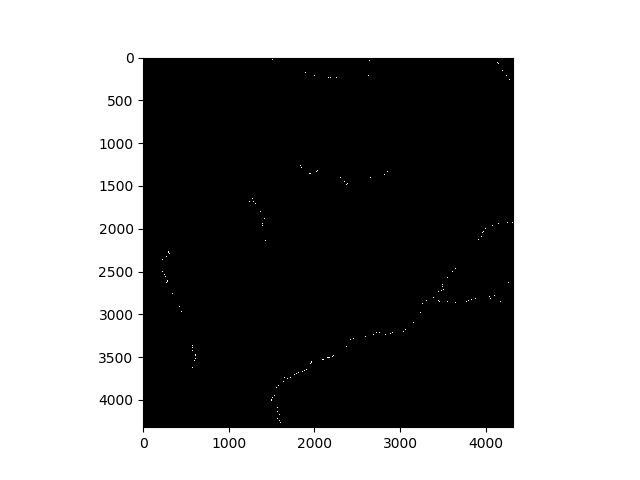

In [255]:
plt.figure()
plt.imshow(raster_rivers, cmap='gist_stern', interpolation=None)
plt.savefig(os.path.join("figures", "riv_raster"), dpi=300)

## Water table elevation raster data

Geoscience Australia also made a raster file of water table elevation (interpolated the contours using TopoToRaster tool in ArcGIS and saved it as ASCII Grid file. This file is not accompanied by a .prj file - i.e. it does not have projection information.

To overcome issues with no projection, my only work-around (for now) was to open the file in ArcGIS and convert it to a Tiff and asign it a projection, I could not figure out how to do this using Python tools.

I am calling this the `wt_rstr_real`, i.e. calling it *real* because it is one that was prepared by a third party, ideally is geologically correct and I can compare it to any interpolation that I do myself.

Note that the cell size is completely different - it is 1000m for this file compared to 30m for the DEM.

In [256]:
wt_rstr_real_file = os.path.join("input_data", "GAB_WT", 
                           "Watertable_Elev", "ASCII_Grid",
                          'wt1.tif')

wt_gab_raster1 = rio.open(wt_rstr_real_file,
                         driverstr="GTiff")

print(type(wt_gab_raster1))

<class 'rasterio.io.DatasetReader'>


### Plot what the real water table raster looks like

<IPython.core.display.Javascript object>


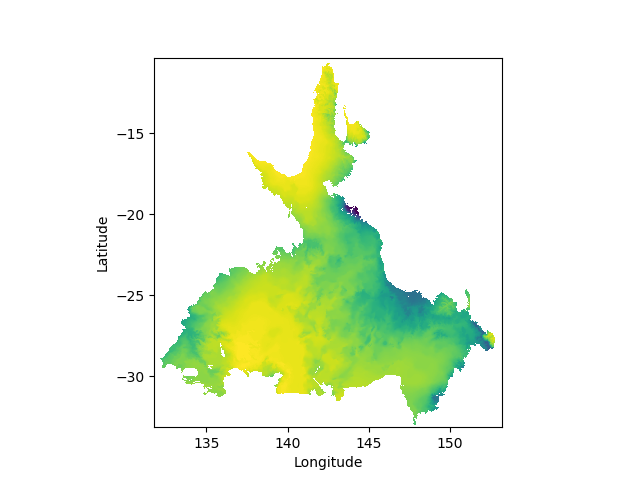

Original raster shape: (2306, 2165)


In [257]:
fig1, ax1 = plt.subplots()
show(wt_gab_raster1, ax=ax1, cmap=wt_cmap)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

print("Original raster shape: %s" %(wt_gab_raster1.shape,))

## Resample this

Reduce size of pixel. Do this so that when I crop it, I can hopefully crop it more successfully to be the same size as the water table map.

I want to *upsample* to convert to a higher resolution/smaller cells.

However, to make the pixels the same size as for the other wt map (30m), this requires too much allocation. So I need to crop it first. But ideally it would be good to crop it just a bit bigger than the study area, so that I don't miss part of the study area when I resample.

### Make a bigger study area

In [259]:
print(type(sa_gdf["geometry"][0]))

print("Now to make a bigger study area")

studyarea_big = shapely.geometry.box(bounds[0]-.1, bounds[1]-.1, bounds[2]+.1, bounds[3]+.1) # minx, miny, maxx, maxy
print(studyarea_big)

print("Original study area size: %2.2f, new big study area size: %2.2f" %(studyarea.area, studyarea_big.area))


sa_df_big = pd.DataFrame()
sa_df_big["geometry"] = [studyarea_big]
sa_gdf_big = gpd.GeoDataFrame(sa_df_big, geometry='geometry',crs=wgs84)
print(sa_gdf_big)
print(sa_gdf)

<class 'shapely.geometry.polygon.Polygon'>
Now to make a bigger study area
POLYGON ((140.2198611113643 -26.14986111115166, 140.2198611113643 -24.74986111113996, 138.8201388891304 -24.74986111113996, 138.8201388891304 -26.14986111115166, 140.2198611113643 -26.14986111115166))
Original study area size: 1.44, new big study area size: 1.96
                                            geometry
0  POLYGON ((140.21986 -26.14986, 140.21986 -24.7...
                                            geometry
0  POLYGON ((140.11986 -26.04986, 140.11986 -24.8...


### Crop area based on a bigger shapefile of my study area

Got notes from here: https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
Use the **big** study area.


In [260]:
with rio.open(wt_rstr_real_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, sa_gdf_big["geometry"], 
                                                  crop=True)
    out_meta = src.meta
    
type(out_image)
out_image.shape
out_image[0].shape

# Different tact --> replace values that are < 0  with np.nan

wt_rstr_gab_crop = np.where(out_image[0] < 0, np.nan, out_image[0])

<IPython.core.display.Javascript object>


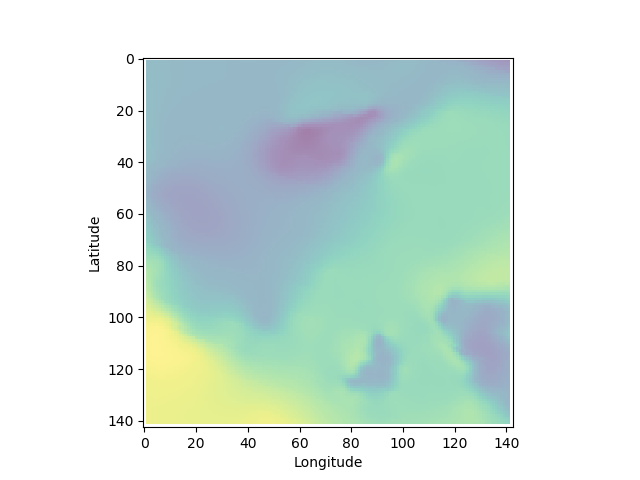

Text(0, 0.5, 'Latitude')

In [265]:
fig1, ax1 = plt.subplots()
show(wt_rstr_gab_crop, ax=ax1, cmap=wt_cmap, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Write this cropped tif of real water table as a new file

In [266]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(os.path.join("output_data", "gab_real_crop_big.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

### Read this tiff back in

In [269]:
wt_gab_raster_real_crop1_nm = os.path.join("output_data", "gab_real_crop_big.tif")

wt_gab_raster_real_crop1 = rio.open(wt_gab_raster_real_crop1_nm, driverstr="GTiff")

<IPython.core.display.Javascript object>


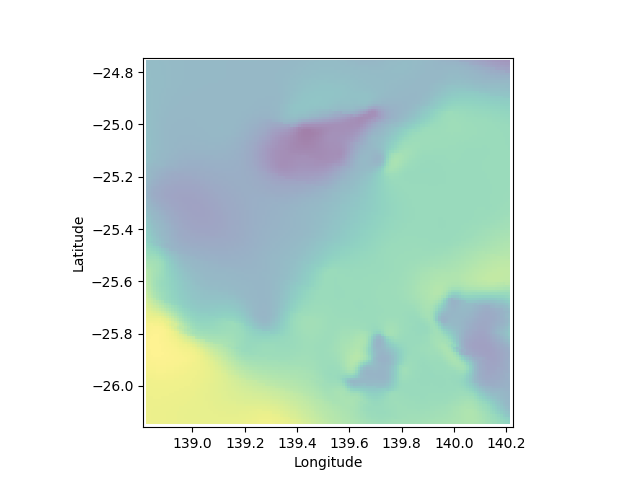

Text(0, 0.5, 'Latitude')

In [270]:
fig1, ax1 = plt.subplots()
show(wt_gab_raster_real_crop1, ax=ax1, cmap=wt_cmap, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Can I sample this raster at specific points?
### Yes I can, so I could use this to set up specific locations to subsample both the DEM and the water table maps to compare them.

Used this: https://gis.stackexchange.com/questions/317391/python-extract-raster-values-at-point-locations

This may be helpful: https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordi 

In [298]:
# Make an arbitraty shapefile


df = pd.DataFrame(
    {'Latitude': [-26.0, -25.8, -25.6, -25.4, -25.2],
     'Longitude': [139.0, 139.2, 139.4, 139.6, 139.8],
    'PointName': ['Point1', 'Point2', 'Point3', 'Point4', 'Point5']})


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


print(gdf.head())


   Latitude  Longitude PointName                     geometry
0     -26.0      139.0    Point1  POINT (139.00000 -26.00000)
1     -25.8      139.2    Point2  POINT (139.20000 -25.80000)
2     -25.6      139.4    Point3  POINT (139.40000 -25.60000)
3     -25.4      139.6    Point4  POINT (139.60000 -25.40000)
4     -25.2      139.8    Point5  POINT (139.80000 -25.20000)


In [312]:
# Read points from shapefile

pts = gdf
print(pts.head())


   Latitude  Longitude PointName                     geometry  Raster Value
0     -26.0      139.0    Point1  POINT (139.00000 -26.00000)     20.545441
1     -25.8      139.2    Point2  POINT (139.20000 -25.80000)     41.530060
2     -25.6      139.4    Point3  POINT (139.40000 -25.60000)     52.323860
3     -25.4      139.6    Point4  POINT (139.60000 -25.40000)     49.921829
4     -25.2      139.8    Point5  POINT (139.80000 -25.20000)     40.277702


In [300]:
pts.index = range(len(pts))

In [310]:
coords = [(x,y) for x, y in zip(pts.Longitude, pts.Latitude)]

# Open the raster and store metadata
src = rio.open(wt_rstr_real_file, driverstr="GTiff") #wt_gab_raster_real_crop1
print(type(src))

<class 'rasterio.io.DatasetReader'>


In [311]:
# Sample the raster at every point location and store values in DataFrame
pts['Raster Value'] = [x[0] for x in src.sample(coords)]

## Resample the cropped study area

In [277]:
from rasterio.enums import Resampling

upscale_factor = 500

with rasterio.open(wt_gab_raster_real_crop1_nm) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
    
print(data.shape)
print(transform)

(1, 71500, 71500)
| 0.00, 0.00, 138.81|
| 0.00,-0.00,-24.74|
| 0.00, 0.00, 1.00|


In [313]:
print(type(data))
print(type(dataset))

<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>


In [314]:
print(data.min())
print(data.max())

-3.402823e+38
86.24828


In [175]:
# Print the array

data_1 = np.copy(data[0,:,:])

filtered_data = np.where(data_1 < 0, np.nan, data_1)

print(type(filtered_data))
print(filtered_data.shape)

<class 'numpy.ndarray'>
(11530, 10825)


Text(0.5, 1.0, 'Real gab wt np array - upscaled')

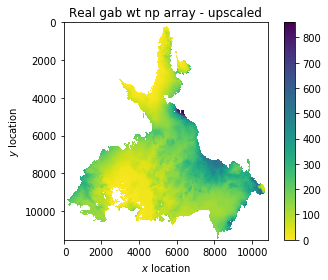

In [180]:
fig, ax = plt.subplots(1)

img = ax.imshow(filtered_data, cmap=wt_cmap)
ax.set_xlabel("$x$ location")
ax.set_ylabel("$y$ location")
ax.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
plt.colorbar(img)


ax.set_title('Real gab wt np array - upscaled')

In [147]:
# make new raster from this data

new_dataset = rasterio.open('test1.tif', 'w', driver='GTiff',
                            height = data.shape[1], width = data.shape[2],
                            count=1, dtype=str(data.dtype),
                            crs='EPSG:4326',
                            transform=transform)
new_dataset.write(data[0,:,:], 1)
new_dataset.close()

print(type(new_dataset))
new_dataset.shape

<class 'rasterio.io.DatasetWriter'>


(11530, 10825)

In [150]:
os.getcwd()

'C:\\Users\\mar886\\WaterTableProject\\aewt_project'

In [151]:
# Now pull this dataset in

wt_rstr_real_file = os.path.join("test1.tif")

wt_gab_raster1_ups = rio.open(wt_rstr_real_file,
                         driverstr="GTiff")

Upscaled raster shape: (11530, 10825)


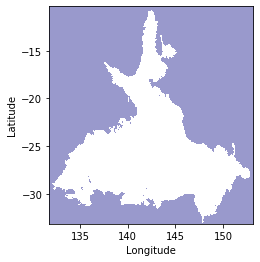

In [152]:
fig1, ax1 = plt.subplots()
show(wt_gab_raster1_ups, ax=ax1, cmap="terrain", alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

print("Upscaled raster shape: %s" %(wt_gab_raster1_ups.shape,))

## Now open the real water table cropped tiff and save it as a np array

**But when compared to the bounding box from my DEM, it can be seen that they are slightly different, not sure what I should do here.**

In [83]:
with rio.open(os.path.join("output_data", "gab_real_crop.tif")) as grd_wt:
    wt_real_crop = grd_wt.read()[0,:,:] # Reads it as a numpy array
    wt_real_crop_meta = grd_wt.profile   # Gets the metadata automatically
    wt_real_crop_bounds = grd_wt.bounds
    wt_real_crop_res = grd_wt.res
    
print(bounds)
print(wt_real_crop_bounds)

print("Shape of the real water table is: %s" %(wt_real_crop.shape,))

BoundingBox(left=138.92013888913038, bottom=-26.049861111151657, right=140.1198611113643, top=-24.849861111139962)
BoundingBox(left=138.9103432122247, bottom=-26.05915118559934, right=140.12623864520972, top=-24.84325575261431)
Shape of the real water table is: (123, 123)


In [105]:
bounds_diff = np.array([bounds[0] - wt_real_crop_bounds[0],
                        bounds[1] - wt_real_crop_bounds[1],
                        bounds[2] - wt_real_crop_bounds[2],
                        bounds[3] - wt_real_crop_bounds[3]])
print(bounds_diff)
type(bounds_diff)

[ 0.00979568  0.00929007 -0.00637753 -0.00660536]


numpy.ndarray

This is in degrees convert to metres --- very very approximate these values are for the equator and from Wikipedia! http://wiki.gis.com/wiki/index.php/Decimal_degrees

In [106]:
degr_conv = 111000 # 1 degre = 111 km

In [108]:
bounds_diff_approx_m = bounds_diff*degr_conv
print(bounds_diff_approx_m)

[1087.32013653 1031.19826369 -707.90625684 -733.19479635]
